<a href="https://colab.research.google.com/github/FaisalT0435/Object-detection-using-Faster-RCNN/blob/master/Faster_RCNN_pytoircj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U torchvision 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 883.7/887.4 MB 173.4 MB/s eta 0:00:01tcmalloc: large alloc 1109270528 bytes == 0x38f3a000 @  0x7f51ce7a0615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 KB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.0 MB/s eta 0:

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu117
0.14.1+cu117


In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Membuat boxes deteksi menggunakan library augmentasi Albumentations 

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

Dataset

Membuat class PetsDetection yang berisi fungsi train data dan labeling 

In [ ]:
class PestDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [ ]:
#Memanggil dataset
dataset_path = "/content/drive/MyDrive/TA/dataset"

In [ ]:
# memanggil file annotation untuk membuat box di data train 
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=10.52s)
creating index...
index created!


{0: {'id': 0, 'name': 'labell-this-image-TA', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'Belalang', 'supercategory': 'labell-this-image-TA'},
 2: {'id': 2, 'name': 'Ulat', 'supercategory': 'labell-this-image-TA'},
 3: {'id': 3, 'name': 'Wereng', 'supercategory': 'labell-this-image-TA'}}

In [ ]:
classes = [i[1]['name'] for i in categories.items()]
classes

['labell-this-image-TA', 'Belalang', 'Ulat', 'Wereng']

In [ ]:
train_dataset = PestDetection(root=dataset_path, transforms=get_transforms(True))
train_dataset[0]

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'boxes': tensor([[ 38.4375,  18.7500, 547.5000, 579.3750]]),
  'labels': tensor([3]),
  'image_id': tensor([0]),
  'area': tensor([285393.1562]),
  'iscrowd': tensor([0])})

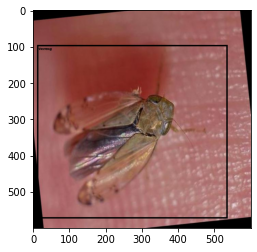

In [ ]:
# contoh data train yang sudah dikasih box
sample = train_dataset[3]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [ ]:
len(train_dataset)

2122

Model Deep Learning Faster RCNN

In [ ]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
in_features

1024

Membuat dataset  untuk memudahkan masuk ke model 

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [ ]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [ ]:
device = torch.device("cuda")

In [ ]:
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
import sys

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = []
    all_losses_dict = []
    for images, targets in tqdm(loader):
      
          images = list(image.to(device) for image in images)
          targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
          
          loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
          losses = sum(loss for loss in loss_dict.values())
          loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
          loss_value = losses.item()
          
          all_losses.append(loss_value)
          all_losses_dict.append(loss_dict_append)
          
          if not math.isfinite(loss_value):
              print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
              print(loss_dict)
              sys.exit(1)
          
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
        
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [ ]:
num_epochs=20

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
#     lr_scheduler.step()

100%|██████████| 531/531 [02:54<00:00,  3.04it/s]


Epoch 0, lr: 0.010000, loss: 0.595126, loss_classifier: 0.227759, loss_box: 0.311770, loss_rpn_box: 0.036576, loss_object: 0.019021


100%|██████████| 531/531 [01:13<00:00,  7.19it/s]


Epoch 1, lr: 0.010000, loss: 0.609131, loss_classifier: 0.226547, loss_box: 0.345377, loss_rpn_box: 0.027294, loss_object: 0.009912


100%|██████████| 531/531 [01:13<00:00,  7.21it/s]


Epoch 2, lr: 0.010000, loss: 0.588351, loss_classifier: 0.218315, loss_box: 0.337804, loss_rpn_box: 0.024233, loss_object: 0.007999


100%|██████████| 531/531 [01:11<00:00,  7.43it/s]


Epoch 3, lr: 0.010000, loss: 0.589878, loss_classifier: 0.208534, loss_box: 0.351474, loss_rpn_box: 0.023006, loss_object: 0.006864


100%|██████████| 531/531 [01:12<00:00,  7.31it/s]


Epoch 4, lr: 0.010000, loss: 0.594581, loss_classifier: 0.215147, loss_box: 0.351824, loss_rpn_box: 0.021763, loss_object: 0.005847


100%|██████████| 531/531 [01:10<00:00,  7.54it/s]


Epoch 5, lr: 0.010000, loss: 0.592701, loss_classifier: 0.209955, loss_box: 0.356289, loss_rpn_box: 0.020679, loss_object: 0.005778


100%|██████████| 531/531 [01:10<00:00,  7.56it/s]


Epoch 6, lr: 0.010000, loss: 0.577573, loss_classifier: 0.203623, loss_box: 0.349715, loss_rpn_box: 0.019743, loss_object: 0.004492


100%|██████████| 531/531 [01:11<00:00,  7.43it/s]


Epoch 7, lr: 0.010000, loss: 0.550093, loss_classifier: 0.191759, loss_box: 0.336029, loss_rpn_box: 0.018153, loss_object: 0.004151


100%|██████████| 531/531 [01:09<00:00,  7.62it/s]


Epoch 8, lr: 0.010000, loss: 0.540190, loss_classifier: 0.185523, loss_box: 0.333460, loss_rpn_box: 0.017297, loss_object: 0.003911


100%|██████████| 531/531 [01:11<00:00,  7.44it/s]


Epoch 9, lr: 0.010000, loss: 0.525169, loss_classifier: 0.181063, loss_box: 0.321841, loss_rpn_box: 0.018059, loss_object: 0.004206


100%|██████████| 531/531 [01:09<00:00,  7.61it/s]


Epoch 10, lr: 0.010000, loss: 0.518815, loss_classifier: 0.177559, loss_box: 0.320151, loss_rpn_box: 0.017076, loss_object: 0.004029


100%|██████████| 531/531 [01:09<00:00,  7.66it/s]


Epoch 11, lr: 0.010000, loss: 0.509322, loss_classifier: 0.174193, loss_box: 0.314835, loss_rpn_box: 0.016746, loss_object: 0.003548


100%|██████████| 531/531 [01:10<00:00,  7.54it/s]


Epoch 12, lr: 0.010000, loss: 0.510825, loss_classifier: 0.176003, loss_box: 0.314337, loss_rpn_box: 0.016925, loss_object: 0.003559


100%|██████████| 531/531 [01:08<00:00,  7.73it/s]


Epoch 13, lr: 0.010000, loss: 0.479643, loss_classifier: 0.163664, loss_box: 0.297373, loss_rpn_box: 0.015662, loss_object: 0.002943


100%|██████████| 531/531 [01:10<00:00,  7.53it/s]


Epoch 14, lr: 0.010000, loss: 0.458523, loss_classifier: 0.157567, loss_box: 0.283384, loss_rpn_box: 0.014911, loss_object: 0.002660


100%|██████████| 531/531 [01:08<00:00,  7.75it/s]


Epoch 15, lr: 0.010000, loss: 0.454784, loss_classifier: 0.157202, loss_box: 0.280960, loss_rpn_box: 0.014111, loss_object: 0.002511


100%|██████████| 531/531 [01:08<00:00,  7.75it/s]


Epoch 16, lr: 0.010000, loss: 0.429443, loss_classifier: 0.148959, loss_box: 0.264123, loss_rpn_box: 0.014100, loss_object: 0.002261


100%|██████████| 531/531 [01:10<00:00,  7.57it/s]


Epoch 17, lr: 0.010000, loss: 0.429762, loss_classifier: 0.148996, loss_box: 0.264303, loss_rpn_box: 0.014029, loss_object: 0.002434


100%|██████████| 531/531 [01:08<00:00,  7.76it/s]


Epoch 18, lr: 0.010000, loss: 0.419385, loss_classifier: 0.141266, loss_box: 0.262405, loss_rpn_box: 0.013217, loss_object: 0.002496


100%|██████████| 531/531 [01:10<00:00,  7.58it/s]

Epoch 19, lr: 0.010000, loss: 0.409571, loss_classifier: 0.139821, loss_box: 0.254399, loss_rpn_box: 0.013087, loss_object: 0.002264


In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = PestDetection(root=dataset_path, split="test1", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


In [ ]:
test_dataset

Dataset PestDetection
    Number of datapoints: 104
    Root location: /content/drive/MyDrive/TA/dataset
    Compose([
  Resize(always_apply=False, p=1, height=600, width=600, interpolation=1),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'coco', 'label_fields': None, 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})

In [ ]:
len(test_dataset)

104

In [ ]:
pred

{'boxes': tensor([[ 58.7740,  46.3139, 586.2416, 503.7072]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([3], device='cuda:0'),
 'scores': tensor([0.9841], device='cuda:0', grad_fn=<IndexBackward0>)}

Score
['Belalang', 'Belalang', 'Belalang', 'Belalang'] :  [0.9992800354957581, 0.9987986087799072, 0.9966828227043152, 0.9943079352378845]
['Wereng'] :  [0.9992934465408325]
['Wereng'] :  [0.999896764755249]
['Wereng'] :  [0.9995232820510864]
['Wereng'] :  [0.9989743232727051]
['Wereng'] :  [0.9995076656341553]
['Ulat'] :  [0.9969741106033325]
['Wereng'] :  [0.9993745684623718]
['Ulat'] :  [0.9968589544296265]


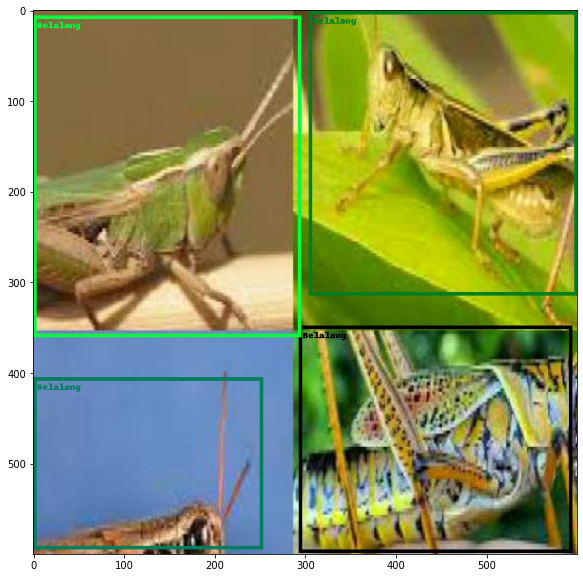

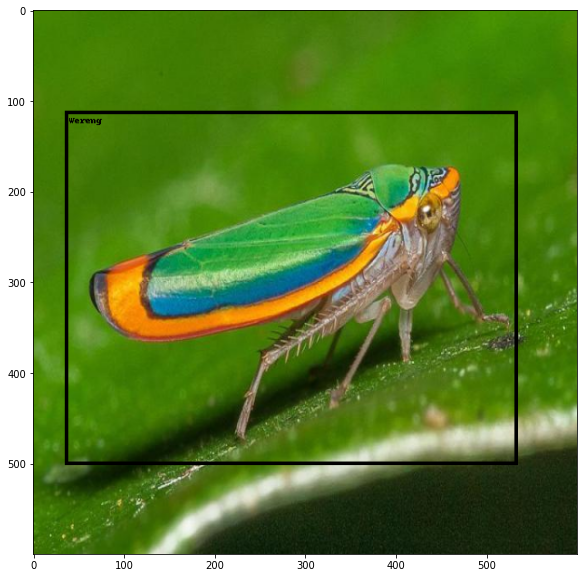

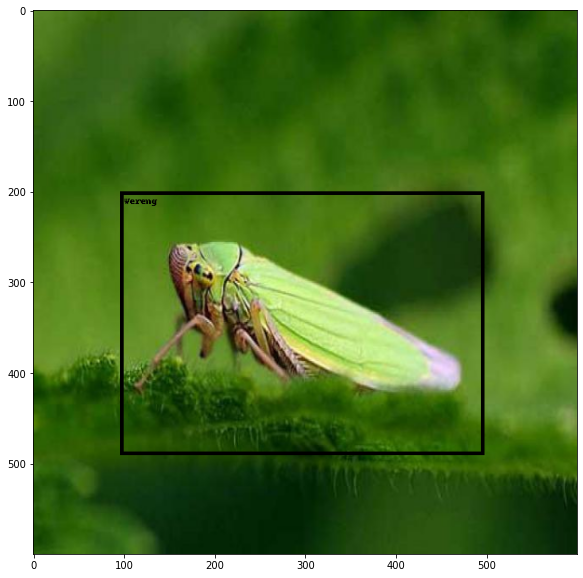

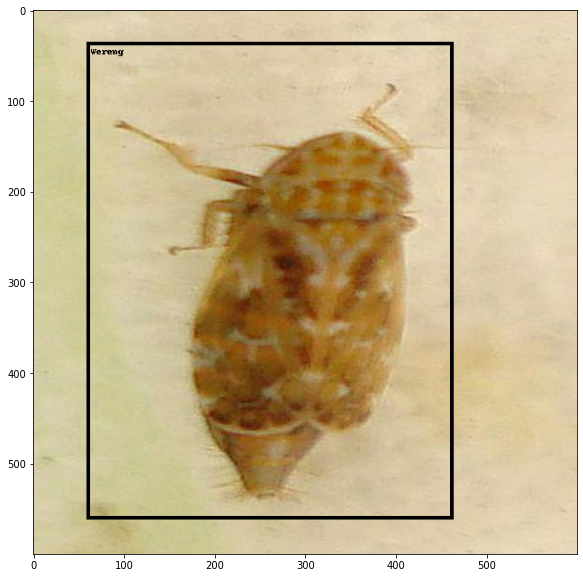

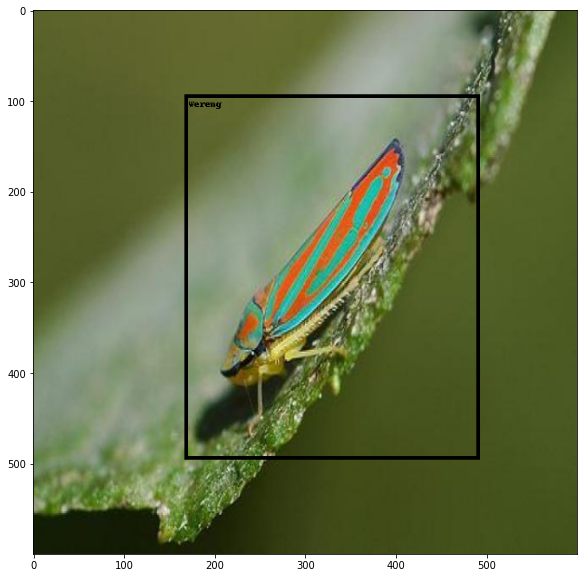

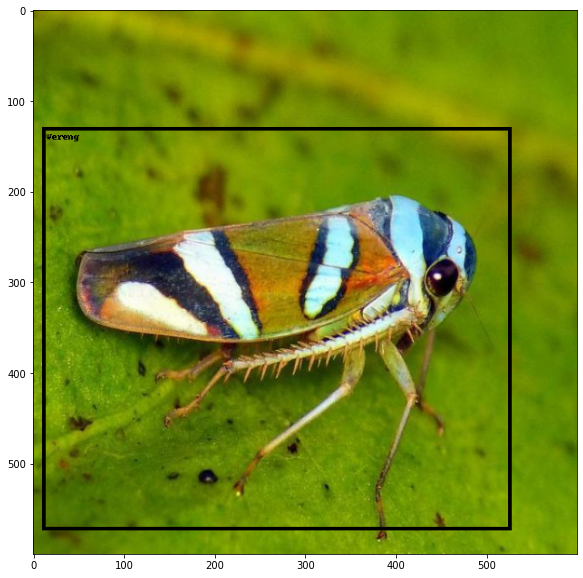

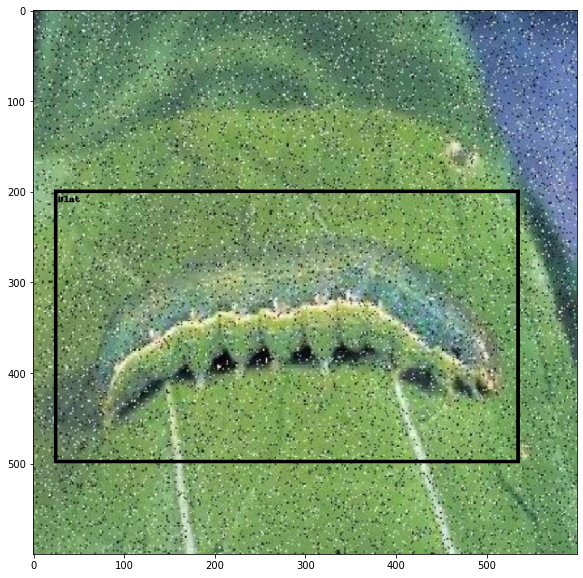

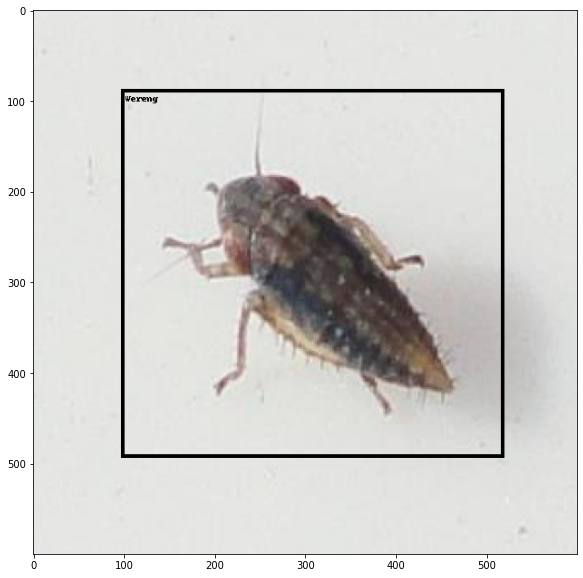

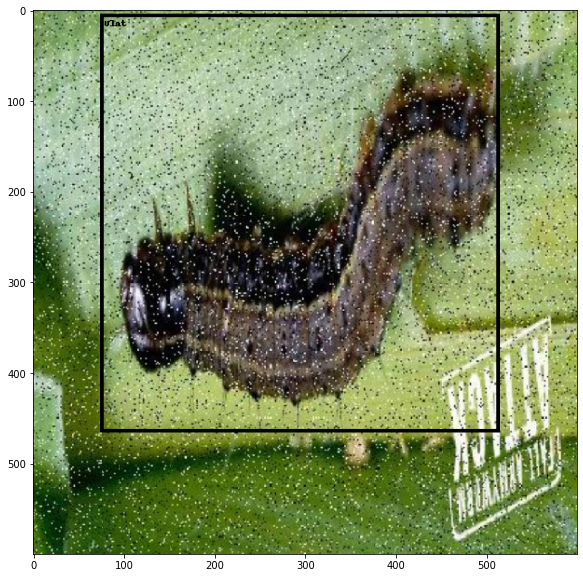

In [ ]:
print("Score")
for i in range(1,10):
  img, _ = test_dataset[i]
  img_int = torch.tensor(img*255, dtype=torch.uint8)
  with torch.no_grad():
      prediction = model([img.to(device)])
      pred = prediction[0]
  
  print( [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], ": ",pred['scores'].tolist() )
  fig = plt.figure(figsize=(14, 10))
  plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8], 
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
  ).permute(1, 2, 0))

  
  
    
  
